# Setup notebook

In [1]:
import os
import sys
from collections import namedtuple

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import utide
from joblib import Parallel, delayed
from matplotlib import dates as mdates
from matplotlib import pyplot as plt
from scipy.signal import argrelmax, argrelmin, find_peaks
from sklearn.linear_model import LinearRegression

sys.path.append("..")
from src import definitions as defs
from src import features, models

%load_ext autoreload
%autoreload 2
%matplotlib widget
%config Completer.use_jedi = False

In [2]:
wdir = defs.ROOT / "data"

# Pre-process Mongla Tidal Data

Import data to pandas dataframe

In [3]:
freq = "30 min"
n_per_hour = pd.Timedelta("1 hour") / pd.Timedelta(freq)
data = pd.read_csv(wdir / "raw" / "mongla_tides.csv", index_col="datetime", parse_dates=True, infer_datetime_format=True)
data = data.reindex(pd.date_range(start=data.index[0], end=data.index[-1], freq=freq, name="datetime")).interpolate(method="time", limit=1, limit_direction="both")
# data = data.loc["1998":"2010"]

Find highs and lows

In [4]:
data[["high", "low"]] = False
distance = n_per_hour * 8

hi = find_peaks(x=data.elevation.values, distance=distance)[0]
lo = find_peaks(x=data.elevation.values * -1, distance=distance)[0]

data.loc[data.iloc[hi].index, "high"] = True
data.loc[data.iloc[lo].index, "low"] = True

Find outliers to exclude from rolling mean

In [5]:
dt = pd.Timedelta("30 days")
stds = 3
r_high = data.elevation.loc[data.high == True].rolling(window=dt, center=True)
top = r_high.mean() + stds * r_high.std()
bot = r_high.mean() -  stds * r_high.std()
highs_for_roll = data.loc[data.high == True].loc[data.loc[data.high == True].elevation.between(bot, top)].elevation

r_low = data.elevation.loc[data.low == True].rolling(window=dt, center=True)
top = r_low.mean() + stds * r_low.std()
bot = r_low.mean()  -  stds * r_low.std()
lows_for_roll = data.loc[data.low == True].loc[data.loc[data.low == True].elevation.between(bot, top)].elevation

# excluded points if needed
highs_excl = data.loc[data.high == True].loc[data.loc[data.high == True].index.difference(other=highs_for_roll.index)]
lows_excl = data.loc[data.low == True].loc[data.loc[data.low == True].index.difference(other=lows_for_roll.index)]

Calculate rolling mean for the data and interpolate for missing values

In [6]:
data["high_roll"] = highs_for_roll.rolling(window=pd.Timedelta("27h"), center=True).mean().reindex(index=data.index).interpolate(method="time", limit_direction="both")
data["low_roll"] = lows_for_roll.rolling(window=pd.Timedelta("27h"), center=True).mean().reindex(index=data.index).interpolate(method="time", limit_direction="both")
data["amp_roll"] = data.high_roll - data.low_roll

Smooth rolling means with Lowess Smooth

In [7]:
window = pd.Timedelta("27 hour")
exog = (data.index - data.index[0]).total_seconds().astype(int)
frac = window / pd.Timedelta(freq) / len(data)
delta = window * 500 / pd.Timedelta(freq)
endogs = (data.high_roll.values, data.low_roll.values)
high_smooth, low_smooth = Parallel(n_jobs=2)(delayed(sm.nonparametric.lowess)(endog=endog, exog=exog, frac=frac, delta=delta, is_sorted=True) for endog in endogs)

Calculate smoothed amplitude

In [8]:
data.loc[pd.TimedeltaIndex(list(zip(*high_smooth))[0], unit="s") + data.index[0], "high_smooth"] = list(zip(*high_smooth))[1]
data.loc[pd.TimedeltaIndex(list(zip(*low_smooth))[0], unit="s") + data.index[0], "low_smooth"] = list(zip(*low_smooth))[1]
data["amp_smooth"] = data.high_smooth - data.low_smooth

Find springs and neaps

In [9]:
data[["spring", "neap"]] = False
distance = n_per_hour * 24 * 11 # search distance in hours
hi = find_peaks(x=data.amp_smooth.values, distance=distance, height=3.0)[0]
lo = find_peaks(x=data.amp_smooth.values * -1, distance=distance, height=-2.5)[0]
data.loc[data.iloc[hi].index, "spring"] = True
data.loc[data.iloc[lo].index, "neap"] = True

Plot subset of data to make sure it looks correct

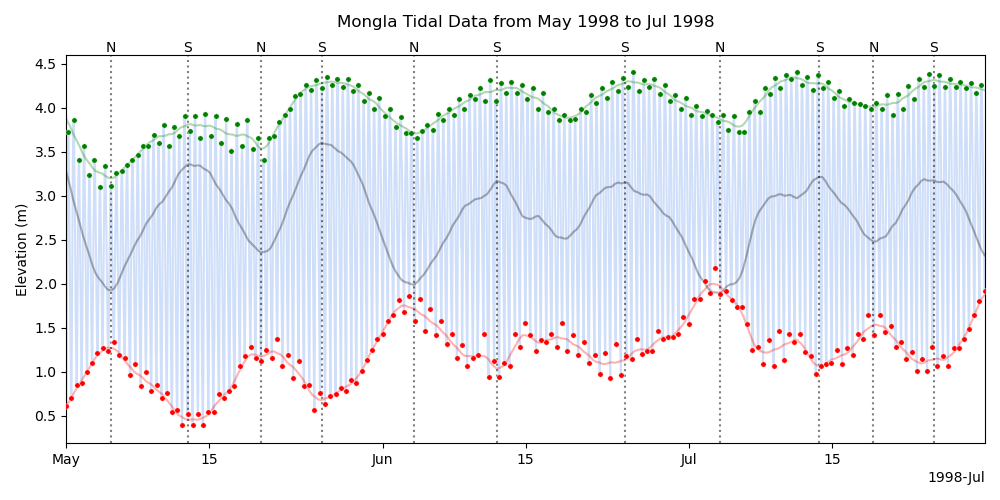

In [10]:
start = pd.to_datetime("1998-05-01")
end = start + pd.Timedelta("90D")

pdata = data.loc[start:end].reset_index()

fig = plt.figure(figsize=(10, 5))
ax = fig.subplots()

sns.lineplot(data=pdata, x="datetime", y="elevation", color="cornflowerblue", alpha=0.3, ax=ax)
sns.lineplot(data=pdata, x="datetime", y="high_smooth", color="green", alpha=0.3, ax=ax)
sns.lineplot(data=pdata, x="datetime", y="low_smooth", color="red", alpha=0.3, ax=ax)
sns.lineplot(data=pdata, x="datetime", y="amp_smooth", color="black", alpha=0.3, ax=ax)

sns.scatterplot(data=pdata.loc[pdata.high == True], x="datetime", y="elevation", color="green", s=15, ax=ax, zorder=15)
sns.scatterplot(data=pdata.loc[pdata.low == True], x="datetime", y="elevation", color="red", s=15, ax=ax, zorder=15)

sns.scatterplot(data=highs_excl.loc[start:end].reset_index(), x="datetime", y="elevation", color="black", marker="X", s=50)
sns.scatterplot(data=lows_excl.loc[start:end].reset_index(), x="datetime", y="elevation", color="black", marker="X", s=50)

for loc in pdata.loc[pdata.spring == True].datetime:
    ax.axvline(x=loc, color="black", linestyle="dotted", alpha=0.5)
    ax.text(x=loc, y=ax.get_ylim()[1], s="S", rotation=0, ha="center", va="bottom")

for loc in pdata.loc[pdata.neap == True].datetime:
    ax.axvline(x=loc, color="black", linestyle="dotted", alpha=0.5)
    ax.text(x=loc, y=ax.get_ylim()[1], s="N", rotation=0, ha="center", va="bottom")

title = "Mongla Tidal Data from {} to {}".format(start.strftime("%b %Y"), end.strftime("%b %Y"))
xlabel = ""
ylabel = "Elevation (m)"
rotation = 0

locator = locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)

ax.xaxis.set(major_locator=locator, major_formatter=formatter)
ax.tick_params(axis='x', labelrotation=rotation)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.set_title(label=title, pad=20)
ax.set_xlim(start, end)
fig.tight_layout()

# Astronomical model of the tides

Set model parameters

In [11]:
lat = 22.4833
start = "1998"
end = "2010"
elev = data.loc[start:end].elevation.values
time = mdates.date2num((data.loc[start:end].index - pd.Timedelta("6 hours")).to_pydatetime())

Create astronomical model with and without nodal correction

In [12]:
coef_nodal = utide.solve(t=time, u=elev, lat=lat, conf_int="MC", method="ols", trend=False, nodal=True, constit="auto", verbose=False)
coef = utide.solve(t=time, u=elev, lat=lat, conf_int="MC", method="ols", trend=False, nodal=False, constit=list(coef_nodal.name), verbose=False)

Reconstruct tidal curves using both models and combine with original data into one df

In [29]:
tide = utide.reconstruct(t=mdates.date2num((data.index - pd.Timedelta("6 hours")).to_pydatetime()), coef=coef, verbose=False)
tide_nodal = utide.reconstruct(t=mdates.date2num((data.index - pd.Timedelta("6 hours")).to_pydatetime()), coef=coef_nodal, verbose=False)
tide_df = pd.DataFrame(data={"mod": tide.h,"mod_n": tide_nodal.h}, index=pd.to_datetime(tide.t_mpl, unit="D") + pd.Timedelta("6 hours"))
tide_df = tide_df.join(other=data.elevation, how="right").rename(columns={"elevation": "obs"})

Reconstruct top six constituents (M2, S2, SA, N2, K1, K2)

In [60]:
dfs = []
top_coefs = coef.name[0:6]
for c in top_coefs:
    tide = utide.reconstruct(t=mdates.date2num((data.index - pd.Timedelta("6 hours")).to_pydatetime()), coef=coef, constit=c, verbose=False)
    tide_nodal = utide.reconstruct(t=mdates.date2num((data.index - pd.Timedelta("6 hours")).to_pydatetime()), coef=coef_nodal, constit=c, verbose=False)
    dfs.append(pd.DataFrame(data={c: tide.h, c+"_n": tide_nodal.h}, index=pd.to_datetime(tide.t_mpl, unit="D") + pd.Timedelta("6 hours")))
constit_df = pd.concat(dfs, axis=1, names="datetime").rename_axis("datetime")

Plot a day of data to visualize constituents

In [130]:
mdates.date2num((data.index - pd.Timedelta("6 hours")).to_pydatetime())

array([ 2556.75      ,  2556.77083333,  2556.79166667, ...,
       16739.6875    , 16739.70833333, 16739.72916667])

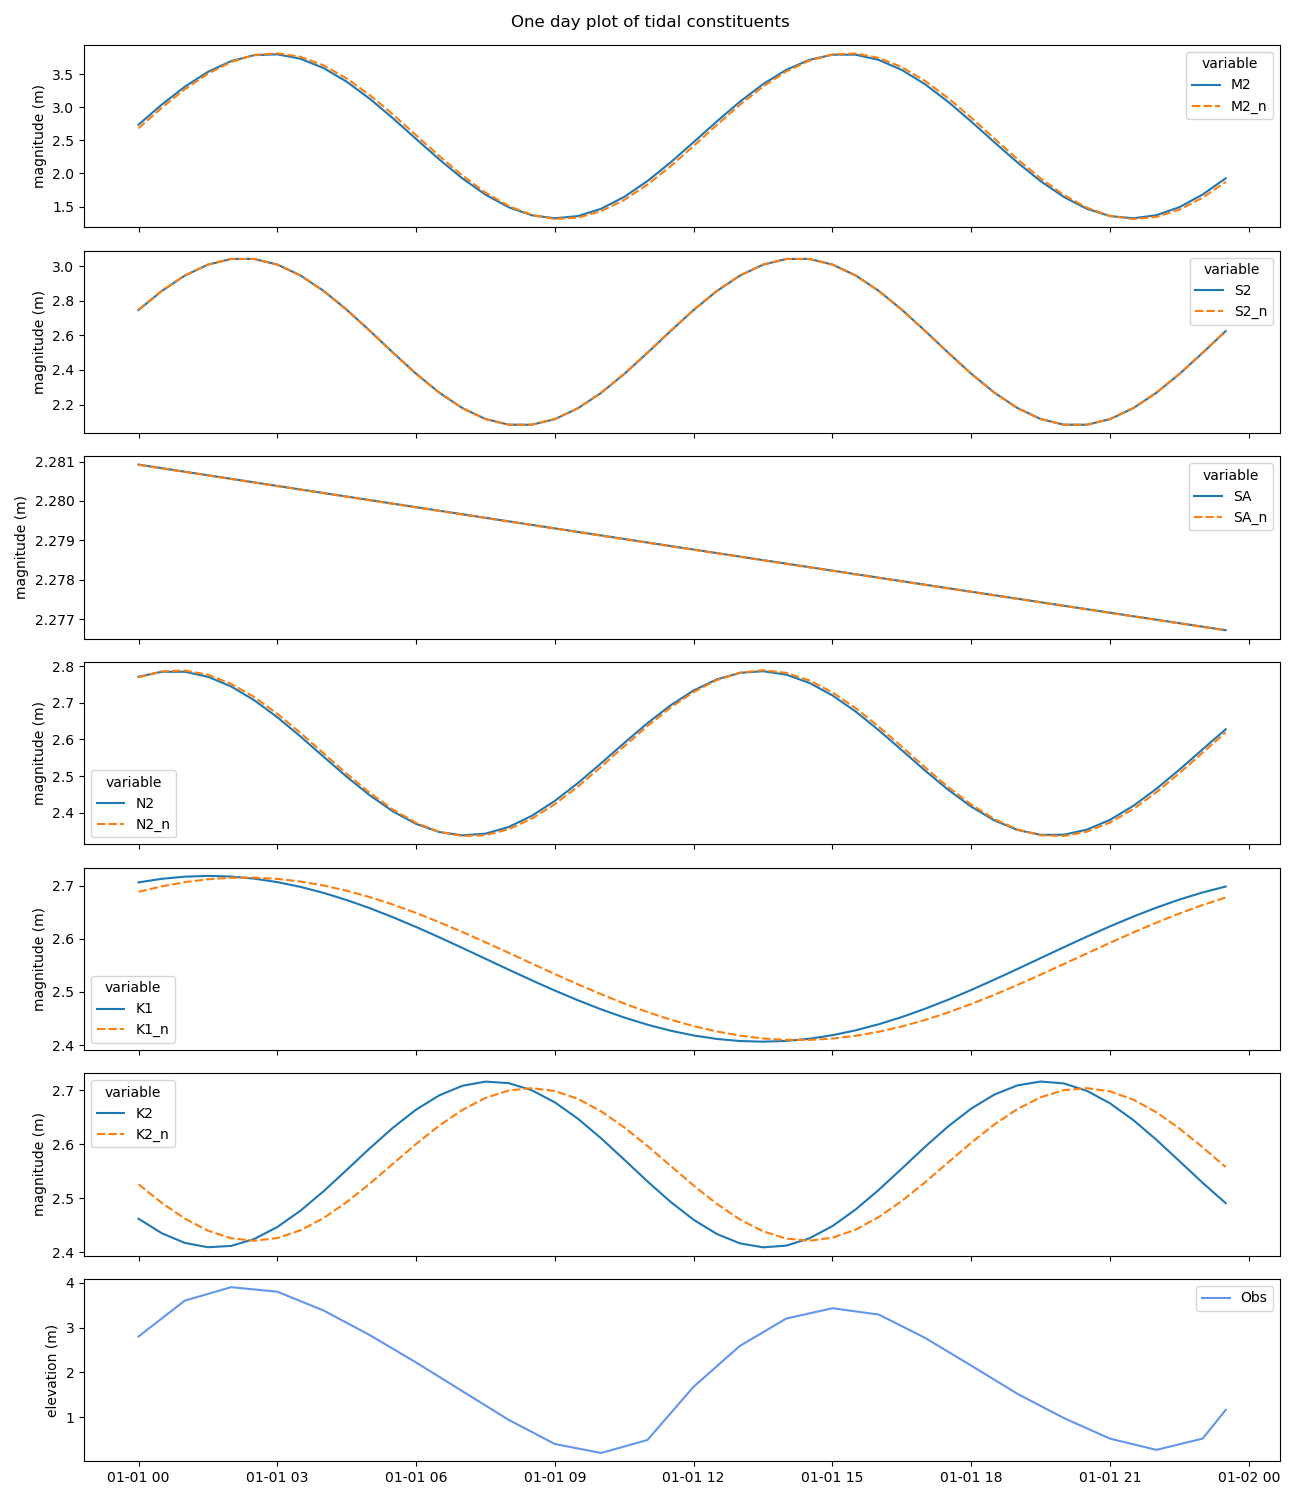

In [127]:
pdata = constit_df.loc["1998-01-01":"1998-01-01"].melt(ignore_index=False).reset_index()

fig = plt.figure(figsize=(13, 15))
ax = fig.subplots(nrows=len(top_coefs)+1, sharex=True)

for i, c in enumerate(top_coefs):
    sns.lineplot(data=pdata.loc[pdata.variable.str.contains("^{}.*$".format(c))], x="datetime", y="value", hue="variable", style="variable", ax=ax[i])
    ax[i].set_ylabel("magnitude (m)")

sns.lineplot(data=tide_df.loc[pdata.datetime.iloc[0]:pdata.datetime.iloc[-1]].reset_index(), x="datetime", y="obs", color="cornflowerblue", ax=ax[-1], label="Obs")

ax[-1].set_ylabel("elevation (m)")
ax[-1].set_xlabel("")
fig.suptitle("One day plot of tidal constituents", y=0.99)
fig.tight_layout()

Find max daily for each constituent. Then find mean monthly max to see nodal effect on each constituent.

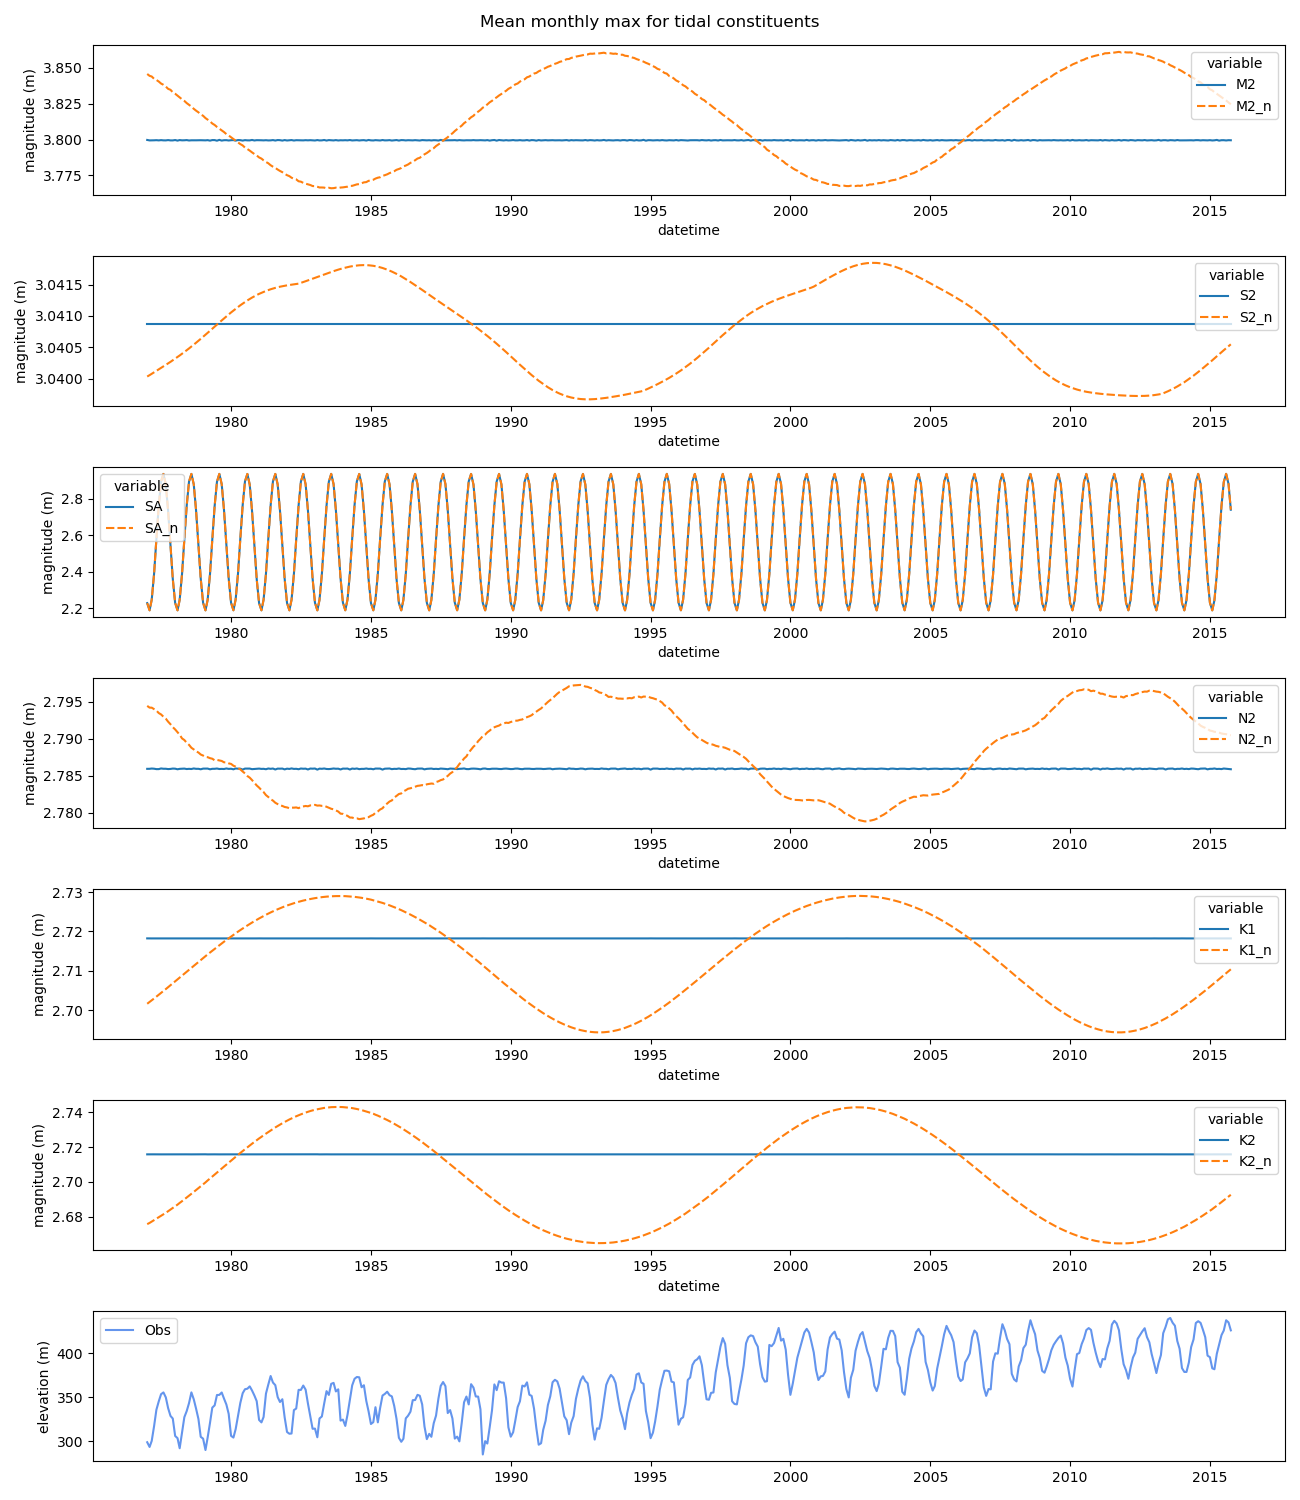

In [138]:
pdata = constit_df.groupby(by=pd.Grouper(freq="1D")).max().groupby(by=pd.Grouper(freq="1MS")).agg("mean").melt(ignore_index=False).reset_index()

fig = plt.figure(figsize=(13, 15))
ax = fig.subplots(nrows=len(top_coefs)+1, sharex=False)

for i, c in enumerate(top_coefs):
    sns.lineplot(data=pdata.loc[pdata.variable.str.contains("^{}.*$".format(c))], x="datetime", y="value", hue="variable", style="variable", ax=ax[i])
    ax[i].set_ylabel("magnitude (m)")

sns.lineplot(data=(tide_df.groupby(by=pd.Grouper(freq="1D")).max().groupby(by=pd.Grouper(freq="1MS")).agg("mean") * 100).reset_index(), x="datetime", y="obs", color="cornflowerblue", ax=ax[-1], label="Obs")

ax[-1].set_ylabel("elevation (m)")
ax[-1].set_xlabel("")
fig.suptitle("Mean monthly max for tidal constituents", y=0.99)
fig.tight_layout()

Plot modeled vs observed monthly MHW

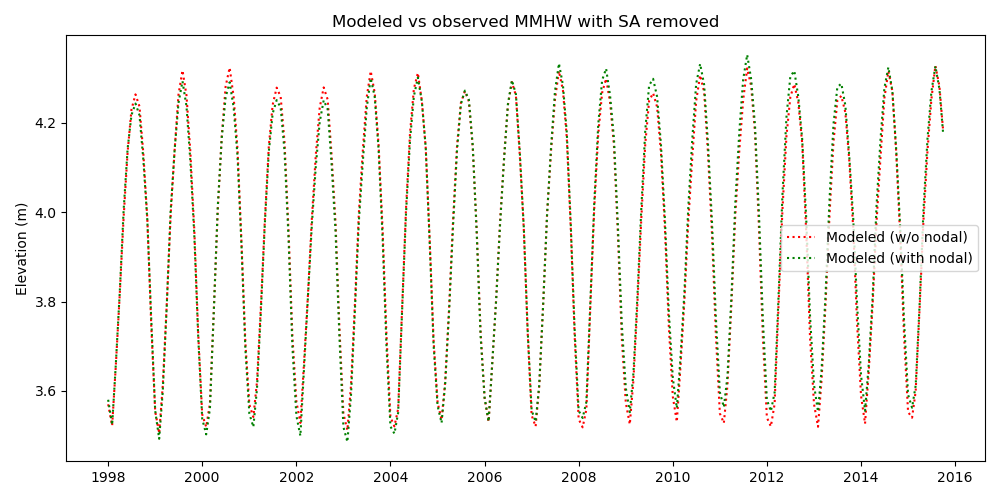

In [135]:
pdata = tide_df
pdata = pdata.loc["1998":].groupby(by=pd.Grouper(freq="1D")).max().groupby(by=pd.Grouper(freq="1MS")).mean().reset_index()

fig = plt.figure(figsize=(10, 5))
ax = fig.subplots()

sns.lineplot(data=pdata, x="datetime", y="mod", color="red", linestyle="dotted", ax=ax, label="Modeled (w/o nodal)")
sns.lineplot(data=pdata, x="datetime", y="mod_n", color="green", linestyle="dotted", ax=ax, label="Modeled (with nodal)")
# sns.lineplot(data=pdata, x="datetime", y="obs", color="cornflowerblue", alpha=0.5, ax=ax, label="Observed")

ax.set_title("Modeled vs observed MMHW with SA removed")
ax.set_ylabel("Elevation (m)")
ax.set_xlabel("")

fig.tight_layout()

Plot difference of MMHW between models

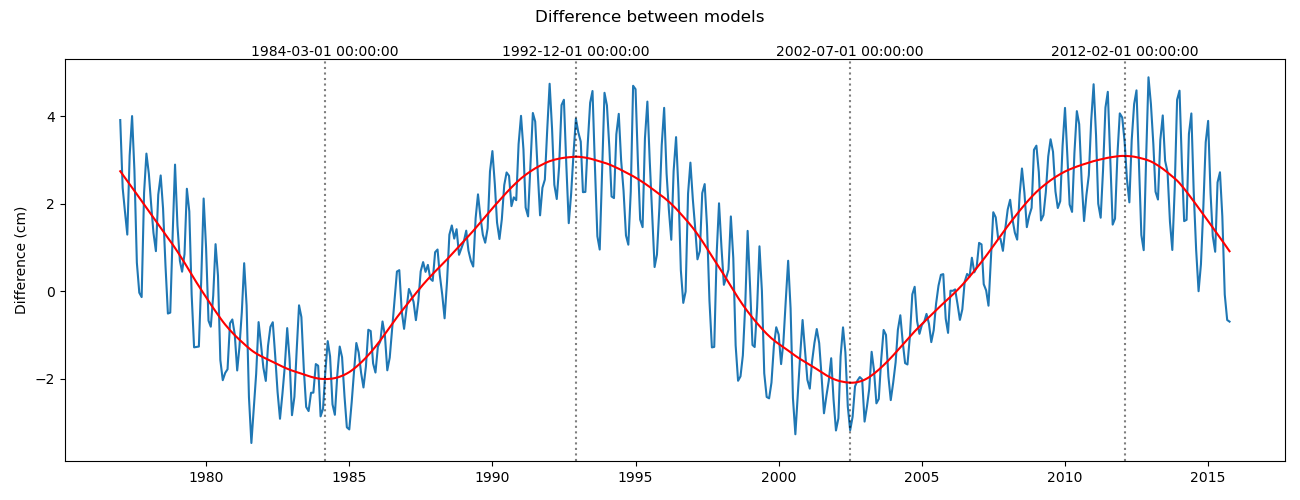

In [108]:
pdata = tide_df.groupby(by=pd.Grouper(freq="1D")).max().groupby(by=pd.Grouper(freq="1MS")).agg("mean") * 100
pdata = (pdata.mod_n - pdata["mod"]).to_frame("difference")
smooth = sm.nonparametric.lowess(endog=pdata.difference.values, exog=(pdata.index - pdata.index[0]).total_seconds().astype(int), frac=0.1, is_sorted=True)
pdata["lowess"] = list(zip(*smooth))[1]

hi = find_peaks(x=pdata.lowess.values, distance=12*18)[0]
lo = find_peaks(x=pdata.lowess.values * -1, distance=12*18)[0]

fig = plt.figure(figsize=(13, 5))
ax = fig.subplots()

sns.lineplot(data=pdata.reset_index(), x="datetime", y="difference", ax=ax)
sns.lineplot(data=pdata.reset_index(), x="datetime", y="lowess", color="red", ax=ax)

for loc in pd.concat([pdata.iloc[hi], pdata.iloc[lo]]).index:
    ax.axvline(x=loc, color="black", linestyle="dotted", alpha=0.5)
    ax.text(x=loc, y=ax.get_ylim()[1], s=loc, rotation=0, ha="center", va="bottom")

fig.suptitle("Difference between models")
ax.set_ylabel("Difference (cm)")
ax.set_xlabel("")

fig.tight_layout()

In [322]:
new_index = pd.date_range(start="2020", end="2034-12-31 23:00:00", freq="1H")
new_data = utide.reconstruct(t=mdates.date2num(new_index.to_pydatetime()), coef=coef_nodal, verbose=False)
tides = pd.DataFrame(data={"elevation": new_data.h, "datetime": new_index}).set_index("datetime")
tides["elapsed"] = tides.index - tides.index[0]

In [323]:
freq = tides.index.freq
n_per_hour = pd.Timedelta("1 hour") / pd.Timedelta(freq)

tides[["high", "low"]] = False
distance = n_per_hour * 8
hi = find_peaks(x=tides.elevation.values, distance=distance)[0]
lo = find_peaks(x=tides.elevation.values * -1, distance=distance)[0]
tides.loc[tides.iloc[hi].index, "high"] = True
tides.loc[tides.iloc[lo].index, "low"] = True

tides["high_roll"] = tides.loc[tides.high == True].elevation.rolling(window=pd.Timedelta("27h"), center=True).mean().reindex(index=tides.index).interpolate(method="time", limit_direction="both")
tides["low_roll"] = tides.loc[tides.low == True].elevation.rolling(window=pd.Timedelta("27h"), center=True).mean().reindex(index=tides.index).interpolate(method="time", limit_direction="both")
tides["amp_roll"] = tides.high_roll - tides.low_roll

In [324]:
tides[["spring", "neap"]] = False
distance = n_per_hour * 24 * 11 # search distance in hours
hi = find_peaks(x=tides.amp_roll.values, distance=distance)[0]
lo = find_peaks(x=tides.amp_roll.values * -1, distance=distance)[0]
tides.loc[tides.iloc[hi].index, "spring"] = True
tides.loc[tides.iloc[lo].index, "neap"] = True

In [325]:
springs = tides.loc[tides.spring == True].apply(
    lambda x: pd.Series(data=(
        tides.loc[tides.high == True].elevation.loc[x.name-pd.Timedelta("13.5 hours"):x.name+pd.Timedelta("13.5 hours")].mean(),
        tides.loc[tides.low == True].elevation.loc[x.name-pd.Timedelta("13.5 hours"):x.name+pd.Timedelta("13.5 hours")].mean()),
        index=("high", "low")),
        axis=1)

neaps = tides.loc[tides.neap == True].apply(
    lambda x: pd.Series(data=(
        tides.loc[tides.high == True].elevation.loc[x.name-pd.Timedelta("13.5 hours"):x.name+pd.Timedelta("13.5 hours")].mean(),
        tides.loc[tides.low == True].elevation.loc[x.name-pd.Timedelta("13.5 hours"):x.name+pd.Timedelta("13.5 hours")].mean()),
        index=("high", "low")),
        axis=1)

In [326]:
springs_yearly = springs.groupby(by=pd.Grouper(freq="AS")).mean().set_index(springs.index.year.unique())

In [327]:
window = pd.Timedelta("14 days")
tides["mean_roll"] = tides.elevation.rolling(window=window, center=True).mean()
beta_sh = 11.9e-3
beta_sl = 3.9e-3

In [329]:
tides["elev_amp"] = np.nan
tides.loc[tides.elevation > tides.mean_roll, "elev_amp"] = tides.loc[tides.elevation > tides.mean_roll].apply(
    lambda row: row.elevation + row.elevation / springs_yearly.high.loc[row.name.year] * beta_sh * row.elapsed / pd.Timedelta("365.25 days"),
    axis=1)

tides.loc[tides.elevation < tides.mean_roll, "elev_amp"] = tides.loc[tides.elevation < tides.mean_roll].apply(
    lambda row: row.elevation - row.elevation / springs_yearly.low.loc[row.name.year] * beta_sl * row.elapsed / pd.Timedelta("365.25 days"),
    axis=1)

In [354]:
plt.close("all")

<AxesSubplot:xlabel='datetime'>

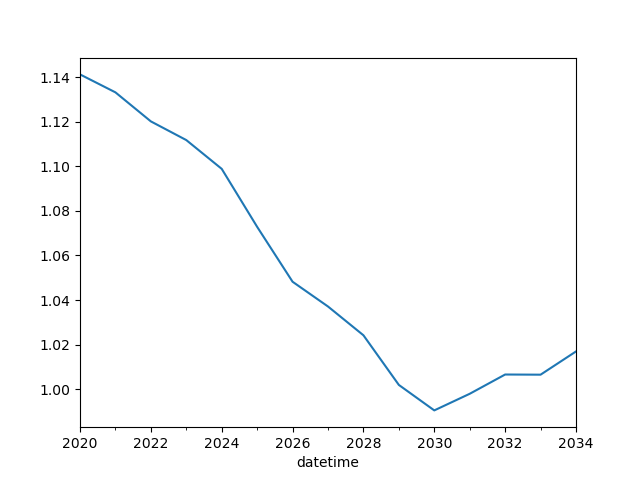

In [355]:
tides.loc[tides.low == True].groupby(pd.Grouper(freq="1AS")).mean().elev_amp.plot()

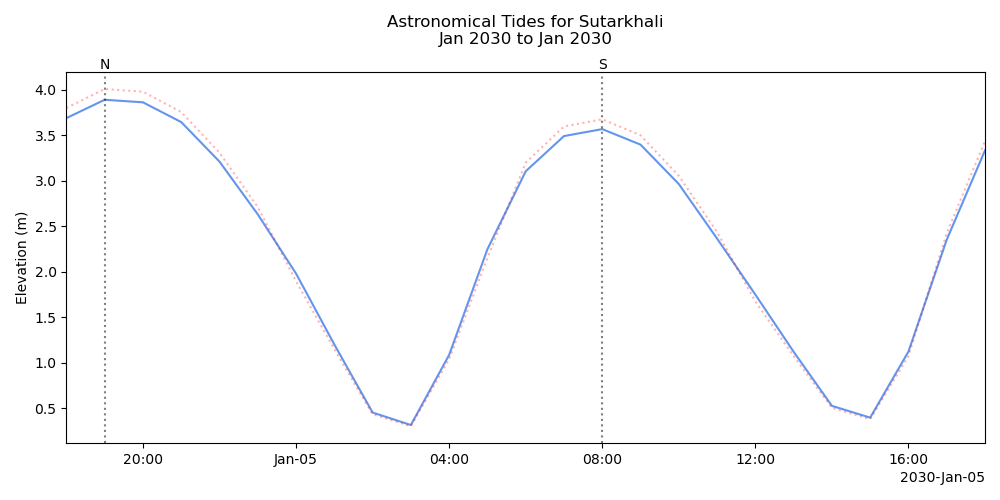

In [342]:
start = pd.to_datetime("2030-01-05").tz_localize(tz="Asia/Dhaka")
end = start + pd.Timedelta("1D")

pdata = tides.loc[start:end].reset_index()

fig = plt.figure(figsize=(10, 5))
ax = fig.subplots()

sns.lineplot(data=pdata, x="datetime", y="elevation", color="cornflowerblue", alpha=1, ax=ax, zorder=1)
sns.lineplot(data=pdata, x="datetime", y="elev_amp", color="red", linestyle="dotted", alpha=0.3, ax=ax, zorder=10)

for loc in pdata.loc[pdata.spring == True].datetime:
    ax.axvline(x=loc, color="black", linestyle="dotted", alpha=0.5)
    ax.text(x=loc, y=ax.get_ylim()[1], s="S", rotation=0, ha="center", va="bottom")

for loc in pdata.loc[pdata.neap == True].datetime:
    ax.axvline(x=loc, color="black", linestyle="dotted", alpha=0.5)
    ax.text(x=loc, y=ax.get_ylim()[1], s="N", rotation=0, ha="center", va="bottom")

title = "Astronomical Tides for Sutarkhali\n{} to {}".format(start.strftime("%b %Y"), end.strftime("%b %Y"))
xlabel = ""
ylabel = "Elevation (m)"
rotation = 0

locator = locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)

ax.xaxis.set(major_locator=locator, major_formatter=formatter)
ax.tick_params(axis='x', labelrotation=rotation)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.set_title(label=title, pad=20)
ax.set_xlim(start, end)
fig.tight_layout()

# Junk

In [259]:
monthly = data.elevation.groupby(pd.Grouper(freq="D")).agg(["max", "min"]).groupby(pd.Grouper(freq="MS")).mean()
monthly["TR"] = monthly["max"] - monthly["min"]
monthly["time"] = (monthly.index - phase_start) / pd.Timedelta("365.25 days")

In [241]:
from scipy.optimize import curve_fit

In [267]:
def mtr(t, a, b, c, d):
    return a + b * t + c * np.cos(2 * np.pi / 18.61 - d)

In [260]:
def mtr(t, b2, b3, e):
    return b2 * np.cos(2 * np.pi / 18.61) + b3 * np.sin(2 * np.pi / 18.61) + e

In [268]:
subset = monthly.loc["1998":"2010"].copy()

In [270]:
(a, b, c, d), pcov = curve_fit(f=mtr, xdata=subset.time.values, ydata=subset.TR.values)

In [271]:
subset["mod"] = a + b * subset.time + c * np.cos(2 * np.pi / 18.61 * subset.time - d)
subset["node"] = c * np.cos(2 * np.pi / 18.61 * subset.time - d)

In [262]:
(b2, b3, e), pcov = curve_fit(f=mtr, xdata=subset.time.values, ydata=subset["max"].values)

In [265]:
np.sqrt(b2**2 + b3**2)

541.8935431927189

In [ ]:
subset["mod"] = a + b * subset.time + c * np.cos(2 * np.pi / 18.61 * subset.time - d)
subset["node"] = b2 * np.cos(2 * np.pi / 18.61) + b3 * np.sin(2 * np.pi / 18.61) + e

<AxesSubplot:xlabel='datetime', ylabel='mod'>

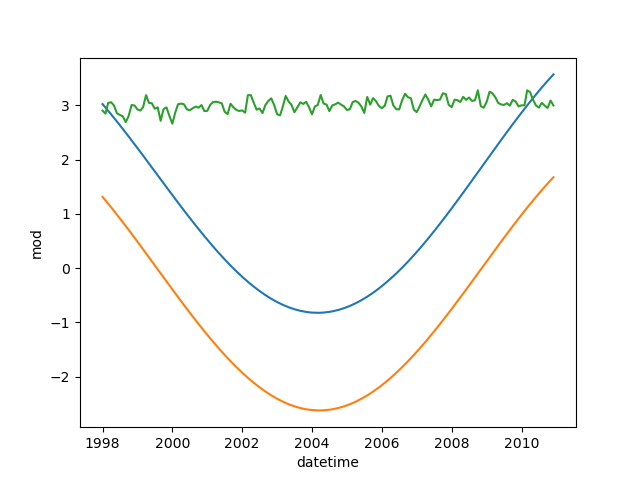

In [275]:
plt.close("all")
sns.lineplot(data=subset.reset_index(), x="datetime", y="mod")
sns.lineplot(data=subset.reset_index(), x="datetime", y="node")
sns.lineplot(data=subset.reset_index(), x="datetime", y="TR")

In [180]:
MTR = monthly.loc["1998":"2010"].TR.mean()
beta = MTR * 0.037
nodal_freq = 18.61
phase_start = pd.to_datetime("2015-10-01")
time = (data.index - phase_start) / pd.Timedelta("365.25 days")

nodal = beta * np.cos(2 * np.pi / nodal_freq * time)

<AxesSubplot:xlabel='datetime', ylabel='datetime'>

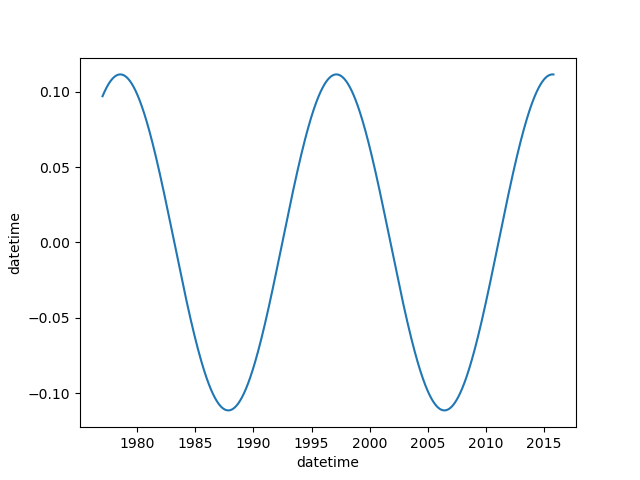

In [181]:
plt.close("all")
sns.lineplot(x=data.index, y=nodal)